In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [3]:
!kaggle datasets download -d plameneduardo/sarscov2-ctscan-dataset

100% 230M/230M [00:13<00:00, 19.8MB/s]
100% 230M/230M [00:13<00:00, 18.6MB/s]


In [4]:
from zipfile import ZipFile
file_name = "/content/sarscov2-ctscan-dataset.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [5]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [6]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import keras
from keras.utils.np_utils import to_categorical
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.layers import  Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet101
# from tensorflow.keras.applications import Xception
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Input
from keras import Model
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from keras import callbacks
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from zipfile import ZipFile

In [7]:
disease_types = ['COVID', 'non-COVID']

train_dir = data_dir = '/content'

train_data = []

for index, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append([sp + "/" + file, index, sp])
        
train = pd.DataFrame(train_data, columns = ['File', 'ID','Disease Type'])
train.head()

,File,ID,Disease Type
0,COVID/Covid (692).png,0,COVID
1,COVID/Covid (672).png,0,COVID
2,COVID/Covid (392).png,0,COVID
3,COVID/Covid (44).png,0,COVID
4,COVID/Covid (150).png,0,COVID


In [8]:
IMAGE_SIZE = 150
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) 
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [9]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
X_Train = X_train / 255.
print(X_Train.shape)

2481it [00:10, 234.48it/s]


(2481, 150, 150, 3)


In [10]:
Y_train = train['ID'].values
Y_train = to_categorical(Y_train, num_classes=3)

In [11]:
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2)

In [12]:
BATCH_SIZE = 64
EPOCHS = 100
SIZE = 150
N_ch=3

In [13]:
from keras.applications import vgg16
def build_VGG16():
    img_rows, img_cols = 150, 150  #image shape = 150*150

    vgg = vgg16.VGG16(weights = 'imagenet', include_top = False, 
              input_shape = (img_rows, img_cols, 3)) # image net has more neurons but we have only 2 hence we are not using the top layer

    # Here we freeze the last 4 layers 
    # Layers are set to trainable as True by default
    for layer in vgg.layers:
      layer.trainable = False  # just copies the weights 
    
    # Let's print our layers 
    for (i,layer) in enumerate(vgg.layers):
      print(str(i) + " "+ layer.__class__.__name__, layer.trainable)
    
    return vgg

In [14]:
def lw(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model 

In [15]:
model = build_VGG16()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.70, patience=5, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('vgg16_Model.hdf5', verbose=1, save_best_only=True)
datagen = ImageDataGenerator(rotation_range=360, 
                        width_shift_range=0.2, 
                        height_shift_range=0.2,
                        zoom_range=0.2, 
                        horizontal_flip=True, 
                        vertical_flip=True) 

datagen.fit(X_train)

58889256/58889256 [==============================] - 3s 0us/step
0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


In [16]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.models import Model

num_classes = 3
FC_Head = lw(model, num_classes)
model = Model(inputs = model.input, outputs = FC_Head)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [17]:
optimizer = Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
model.compile(loss = 'categorical_crossentropy', optimizer=optimizer,metrics = ['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [18]:
X_train.shape[0]
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=25,
               epochs=EPOCHS,
               verbose=1,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

<ipython-input-18-c987a3acef92>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),


Epoch 1/100
25/25 [==============================] - ETA: 0s - loss: 0.8721 - accuracy: 0.5213
Epoch 1: val_loss improved from inf to 0.74229, saving model to vgg16_Model.hdf5
25/25 [==============================] - 23s 520ms/step - loss: 0.8721 - accuracy: 0.5213 - val_loss: 0.7423 - val_accuracy: 0.5996 - lr: 0.0050
Epoch 2/100
25/25 [==============================] - ETA: 0s - loss: 0.7146 - accuracy: 0.5725
Epoch 2: val_loss improved from 0.74229 to 0.68801, saving model to vgg16_Model.hdf5
25/25 [==============================] - 10s 396ms/step - loss: 0.7146 - accuracy: 0.5725 - val_loss: 0.6880 - val_accuracy: 0.6459 - lr: 0.0050
Epoch 3/100
25/25 [==============================] - ETA: 0s - loss: 0.6827 - accuracy: 0.5994
Epoch 3: val_loss improved from 0.68801 to 0.66785, saving model to vgg16_Model.hdf5
25/25 [==============================] - 10s 398ms/step - loss: 0.6827 - accuracy: 0.5994 - val_loss: 0.6678 - val_accuracy: 0.6720 - lr: 0.0050
Epoch 4/100
25/25 [==========

In [19]:


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']



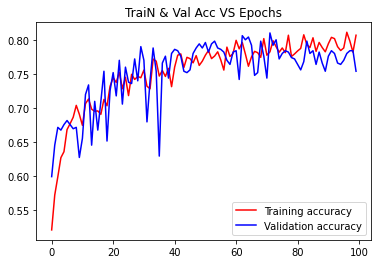

<Figure size 432x288 with 0 Axes>

In [20]:


epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('TraiN & Val Acc VS Epochs')
plt.legend(loc=0)
plt.figure()
plt.show()



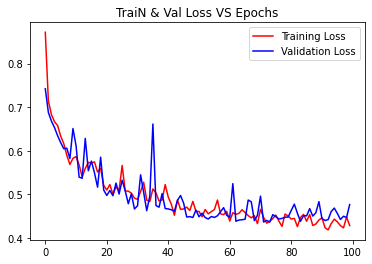

<Figure size 432x288 with 0 Axes>

In [21]:
epochs = range(len(acc))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('TraiN & Val Loss VS Epochs')
plt.legend(loc=0)
plt.figure()
plt.show()

In [22]:
model.load_weights("vgg16_Model.hdf5")
model.save('/content/drive/MyDrive/Model Saves/VGG16 CT-Scan')
score = model.evaluate(X_val, Y_val ,verbose=1)
print('Test Loss:', score[0])
print('Test accuracy:', score[1]*100)

16/16 [==============================] - 1s 84ms/step - loss: 0.4363 - accuracy: 0.8008
Test Loss: 0.4362782835960388
Test accuracy: 80.0804853439331


In [23]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import numpy as np

In [25]:
pred = model.predict(X_val)
rounded_labels_1 = np.argmax(pred, axis=1)
rounded_labels_2 = np.argmax(Y_val, axis=1)
rounded_labels_1[1]
rounded_labels_2[1]
accuracy_score(rounded_labels_2,rounded_labels_1)
print(confusion_matrix(rounded_labels_2,rounded_labels_1))
print(classification_report(rounded_labels_2,rounded_labels_1))

16/16 [==============================] - 1s 85ms/step
[[198  66]
 [ 33 200]]
              precision    recall  f1-score   support

           0       0.86      0.75      0.80       264
           1       0.75      0.86      0.80       233

    accuracy                           0.80       497
   macro avg       0.80      0.80      0.80       497
weighted avg       0.81      0.80      0.80       497

